# Task 4: Daily Demand Simulator for BotWorld's European Expansion

This notebook implements a **daily demand simulator** for BotWorld's MyBot product line across Europe (2027–2034).

### Key design choices:

- **Population data**: Metro city populations from `1.1_Ty.xlsx` (2026 base), projected using each country's growth rate. Non-metro = country overall minus sum of metro cities.
- **Market entry years**: 2027 (BE, DE, LU, NL), 2028 (DK, EE, FI, LV, LT, NO, PL, SE), 2029 (AT, FR, IE, IT, PT, ES, CH), 2030 (BG, HR, CY, CZ, GR, HU, MT, RO, SK, SI).
- **Day-of-week weights**: Mo=12%, Tu=12%, We=23%, Th=25%, Fr=15%, Sa=10%, Su=3%.
- **13 four-week period seasonal shares**: [0.05, 0.07, 0.09, 0.09, 0.09, 0.05, 0.04, 0.06, 0.13, 0.09, 0.06, 0.07, 0.11] — drawn from **Normal** (CV=25%), renormalised to sum=100%.
- **Cyber Week** (Black Friday to Cyber Monday): 15% of yearly demand, prices ~15% lower.
- **24 MyBot models** across 6 categories × 4 capability levels.

### Stochastic components:
| Component | Distribution | Per-year seed? |
|---|---|---|
| Seasonal period shares (13 periods) | Normal(μ, CV=25%·μ), renormalised | Global RNG stream |
| **Annual adoption/growth rate** | **Triangular(pes, mp, opt)** — pes=~5th pct, mp=mode, opt=~95th pct | **Fresh seed each (year, sim)** |
| **Product model share mix (24 SKUs)** | **Triangular(base·0.8, base, base·1.2)**, renormalised | **Fresh seed each (year, sim)** |


## 1. Setup & Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 2. Population Data from 1.1_Ty.xlsx

Metro cities and 2026 populations are extracted directly from the file. Country growth rates are applied to project forward. Non-metro population = country overall − sum of metro cities.

In [13]:
# ── Raw metro city data from 1.1_Ty.xlsx (Transfer sheet) ──────────────────
# Structure: country, city, 2026_pop  (extracted programmatically below)

import openpyxl

wb = openpyxl.load_workbook('1.1_Ty.xlsx', data_only=True)
country = wb['Country']
city = wb['City']

metro_rows = []
country_stats = {}   # {country: {metro_pop, overall_pop, growth_rate}}

current_country = None
for row in country.iter_rows(min_row=2, values_only=True):
    stat_country, metro_stat, nonmetro_stat, overall_stat, gr = row[0], row[1], row[2], row[3], row[4]

    # Collect country-level stats from the right-hand table
    if isinstance(stat_country, str) and isinstance(overall_stat, (int, float)) and gr is not None:
        country_stats[stat_country] = {
            'metro_pop_2026':    metro_stat,
            'nonmetro_pop_2026': nonmetro_stat,
            'overall_pop_2026':  overall_stat,
            'growth_rate':       gr
        }

    # Collect metro city rows
for row in city.iter_rows(values_only=True):
    country_col, city_col, pop_col = row[0], row[1], row[2]
    if isinstance(country_col, str):
        current_country = country_col
    if current_country and isinstance(city_col, str) and isinstance(pop_col, (int, float)):
        metro_rows.append({'Country': current_country, 'City': city_col, 'Pop_2026': int(pop_col)})

metro_df = pd.DataFrame(metro_rows)
print(f'Metro cities: {len(metro_df)}')
print(f'Countries with stats: {len(country_stats)}')
metro_df.head(10)

Metro cities: 273
Countries with stats: 29


,Country,City,Pop_2026
0,Belgium,Brussels,2150320
1,Belgium,Antwerp,1068660
2,Belgium,Liege,690769
3,Belgium,Gent,480931
4,Belgium,Charleroi,420510
5,Germany,Berlin,3584240
6,Germany,Hamburg,1788890
7,Germany,Munich,1596050
8,Germany,Koeln,963395
9,Germany,Frankfurt am Main,650000


In [15]:
# ── Country growth rates table ──────────────────────────────────────────────
country_stats_df = pd.DataFrame(country_stats).T.reset_index().rename(columns={'index':'Country'})
country_stats_df[['metro_pop_2026','nonmetro_pop_2026','overall_pop_2026','growth_rate']] = \
    country_stats_df[['metro_pop_2026','nonmetro_pop_2026','overall_pop_2026','growth_rate']].apply(pd.to_numeric)
print(country_stats_df.to_string(index=False))

       Country  metro_pop_2026  nonmetro_pop_2026  overall_pop_2026  growth_rate
       Belgium       4811190.0          6963410.0        11774600.0       0.0014
       Germany      24826161.0         58818139.0        83644300.0      -0.0051
   Netherlands       4635967.0         13812833.0        18448800.0       0.0143
       Denmark       1647231.0          4376289.0         6023520.0       0.0056
       Estonia        458713.0           872347.0         1331060.0       0.0035
       Finland       2337480.0          3284260.0         5621740.0      -0.0098
        Latvia        612980.0          1222960.0         1835940.0      -0.0003
     Lithuania       1108314.0          1689026.0         2797340.0      -0.0095
        Norway       1343695.0          4309295.0         5652990.0      -0.0116
        Poland       9207380.0         28635820.0        37843200.0       0.0053
        Sweden       2747454.0          7953546.0        10701000.0      -0.0078
       Austria       2836381

In [ ]:
# ── Project metro & non-metro populations 2027–2034 ─────────────────────────
YEARS = list(range(2027, 2035))

# Map growth rate to each metro city via country
metro_df = metro_df.merge(country_stats_df[['Country','growth_rate']], on='Country', how='left')

for yr in YEARS:
    n = yr - 2026  # years since base
    metro_df[f'Pop_{yr}'] = (metro_df['Pop_2026'] * (1 + metro_df['growth_rate'])**n).round(0).astype(int)

# Non-metro: overall country minus sum of all metro cities for that country
metro_sum = metro_df.groupby('Country')[[f'Pop_{yr}' for yr in YEARS]].sum().reset_index()
metro_sum = metro_sum.rename(columns={f'Pop_{yr}': f'MetroSum_{yr}' for yr in YEARS})

nonmetro_df = country_stats_df.copy()
for yr in YEARS:
    n = yr - 2026
    nonmetro_df[f'OverallPop_{yr}'] = (nonmetro_df['overall_pop_2026'] * (1 + nonmetro_df['growth_rate'])**n).round(0)

nonmetro_df = nonmetro_df.merge(metro_sum, on='Country', how='left')
for yr in YEARS:
    nonmetro_df[f'NonMetroPop_{yr}'] = (nonmetro_df[f'OverallPop_{yr}'] - nonmetro_df[f'MetroSum_{yr}']).clip(lower=0).round(0)
    # clip method cap values to a range

print('Metro (first 5):')
print(metro_df[['Country','City','Pop_2026','Pop_2027','Pop_2028']].head())
print('\nNon-Metro (first 5):')
print(nonmetro_df[['Country','NonMetroPop_2027','NonMetroPop_2028']].head())

Metro (first 5):
   Country       City  Pop_2026  Pop_2027  Pop_2028
0  Belgium   Brussels   2150320   2153330   2156345
1  Belgium    Antwerp   1068660   1070156   1071654
2  Belgium      Liege    690769    691736    692705
3  Belgium       Gent    480931    481604    482279
4  Belgium  Charleroi    420510    421099    421688

Non-Metro (first 5):
       Country  NonMetroPop_2027  NonMetroPop_2028
0      Belgium         6973159.0         6982921.0
1      Germany        58518166.0        58219725.0
2  Netherlands        14010356.0        14210705.0
3      Denmark         4400797.0         4425440.0
4      Estonia          875401.0          878464.0


## 3. Demand Parameters

annual demad growth rate leaves questionable

In [17]:
# ── Market entry years ───────────────────────────────────────────────────────
ENTRY_YEAR = {
    'Belgium': 2027, 'Germany': 2027, 'Luxembourg': 2027, 'Netherlands': 2027,
    'Denmark': 2028, 'Estonia': 2028, 'Finland': 2028, 'Latvia': 2028,
    'Lithuania': 2028, 'Norway': 2028, 'Poland': 2028, 'Sweden': 2028,
    'Austria': 2029, 'France': 2029, 'Ireland': 2029, 'Italy': 2029,
    'Portugal': 2029, 'Spain': 2029, 'Switzerland': 2029,
    'Bulgaria': 2030, 'Croatia': 2030, 'Cyprus': 2030, 'Czech Republic': 2030,
    'Greece': 2030, 'Hungary': 2030, 'Malta': 2030, 'Romania': 2030,
    'Slovakia': 2030, 'Slovenia': 2030
}

# ── Annual adoption rate (Most Probable) ────────────────────────────────────
# Year 1: 0.025%; Year 2: +0.02% → 0.045%; Year 3: +0.01% → 0.055%; Year 4+: +0.005%/yr
def adoption_rate_mp(market_year: int) -> float:
    """Cumulative annual demand rate as % of population (most probable)."""
    if market_year <= 0:
        return 0.0
    base = 0.00025
    if market_year == 1: return base
    base += 0.0002
    if market_year == 2: return base
    base += 0.0001
    if market_year == 3: return base
    return base + (market_year - 3) * 0.00005

# ── Optimistic (99%) and Pessimistic (99%) rates ─────────────────────────────
def adoption_rate_opt(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0005
    if market_year == 1: return base
    base += 0.00025
    if market_year == 2: return base
    base += 0.0002
    if market_year == 3: return base
    return base + (market_year - 3) * 0.0001

def adoption_rate_pes(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0002
    if market_year == 1: return base
    base += 0.0001
    if market_year == 2: return base
    base += 0.00005
    if market_year == 3: return base
    return max(0, base + (market_year - 3) * (-0.00002))

# Print adoption table
print('Market Year | MP rate   | Opt rate  | Pes rate')
for my in range(1, 9):
    print(f'     {my}      | {adoption_rate_mp(my)*100:.4f}%  | {adoption_rate_opt(my)*100:.4f}%  | {adoption_rate_pes(my)*100:.4f}%')

Market Year | MP rate   | Opt rate  | Pes rate
     1      | 0.0250%  | 0.0500%  | 0.0200%
     2      | 0.0450%  | 0.0750%  | 0.0300%
     3      | 0.0550%  | 0.0950%  | 0.0350%
     4      | 0.0600%  | 0.1050%  | 0.0330%
     5      | 0.0650%  | 0.1150%  | 0.0310%
     6      | 0.0700%  | 0.1250%  | 0.0290%
     7      | 0.0750%  | 0.1350%  | 0.0270%
     8      | 0.0800%  | 0.1450%  | 0.0250%


In [18]:
# ── MyBot model catalogue ────────────────────────────────────────────────────
# 6 categories × 4 capability levels = 24 models
# Prices from PDF page 2 table; shares from task 1.2 notebook (Model_master.xlsx)
MODELS = [
    # (Model,  Category,  Level, Price_EUR, Share_MP)
    ('F10', 'Floor Care',        10, 360, 0.17),
    ('K10', 'Kitchen Help',      10, 360, 0.13),
    ('S10', 'Safety & Security', 10, 360, 0.10),
    ('W10', 'Wall & Window',     10, 360, 0.09),
    ('F20', 'Floor Care',        20, 480, 0.08),
    ('K20', 'Kitchen Help',      20, 480, 0.06),
    ('L20', 'Leisure',           20, 480, 0.05),
    ('S20', 'Safety & Security', 20, 480, 0.05),
    ('W20', 'Wall & Window',     20, 480, 0.04),
    ('X20', 'Exterior Care',     20, 480, 0.04),
    ('F30', 'Floor Care',        30, 600, 0.04),
    ('K30', 'Kitchen Help',      30, 600, 0.03),
    ('L30', 'Leisure',           30, 600, 0.03),
    ('S30', 'Safety & Security', 30, 600, 0.03),
    ('W30', 'Wall & Window',     30, 600, 0.02),
    ('X30', 'Exterior Care',     30, 600, 0.02),
    ('F50', 'Floor Care',        50, 720, 0.02),
    ('K50', 'Kitchen Help',      50, 720, 0.02),
    ('L50', 'Leisure',           50, 720, 0.01),
    ('S50', 'Safety & Security', 50, 720, 0.01),
    ('W50', 'Wall & Window',     50, 720, 0.01),
    ('X50', 'Exterior Care',     50, 720, 0.01),
    ('L10', 'Leisure',           10, 360, 0.02),
    ('X10', 'Exterior Care',     10, 360, 0.02),
]

model_df = pd.DataFrame(MODELS, columns=['Model','Category','Level','Price_EUR','Share_MP'])
# Normalise shares to exactly 1.0
model_df['Share_MP'] = model_df['Share_MP'] / model_df['Share_MP'].sum()

# Cluster assignment 
CLUSTER1 = {'Floor Care', 'Kitchen Help', 'Leisure'}
CLUSTER2 = {'Safety & Security', 'Wall & Window', 'Exterior Care'}
model_df['Cluster'] = model_df['Category'].apply(lambda c: 1 if c in CLUSTER1 else 2)

print(model_df.to_string(index=False))

Model          Category  Level  Price_EUR  Share_MP  Cluster
  F10        Floor Care     10        360  0.154545        1
  K10      Kitchen Help     10        360  0.118182        1
  S10 Safety & Security     10        360  0.090909        2
  W10     Wall & Window     10        360  0.081818        2
  F20        Floor Care     20        480  0.072727        1
  K20      Kitchen Help     20        480  0.054545        1
  L20           Leisure     20        480  0.045455        1
  S20 Safety & Security     20        480  0.045455        2
  W20     Wall & Window     20        480  0.036364        2
  X20     Exterior Care     20        480  0.036364        2
  F30        Floor Care     30        600  0.036364        1
  K30      Kitchen Help     30        600  0.027273        1
  L30           Leisure     30        600  0.027273        1
  S30 Safety & Security     30        600  0.027273        2
  W30     Wall & Window     30        600  0.018182        2
  X30     Exterior Care 

In [21]:
# ── Day-of-week weights ──────────────────────────────────────────────────────
# Mo=12, Tu=12, We=23, Th=25, Fr=15, Sa=10, Su=3  (sum=100)
DOW_WEIGHTS = np.array([0.12, 0.12, 0.23, 0.25, 0.15, 0.10, 0.03])  # Mon=0..Sun=6
assert abs(DOW_WEIGHTS.sum() - 1.0) < 1e-9

# ── 13-period seasonal shares (excl. Cyber Week) ─────────────────────────────
# Each period = 4 weeks = 28 days; 13 × 28 = 364 days + 1 extra day handled later
PERIOD_SHARES_BASE = np.array([0.05, 0.07, 0.09, 0.09, 0.09, 0.05, 0.04,
                                0.06, 0.13, 0.09, 0.06, 0.07, 0.11])
assert abs(PERIOD_SHARES_BASE.sum() - 1.0) < 1e-9, f'Sum={PERIOD_SHARES_BASE.sum()}'

# Cyber Week = 5 days (Black Friday through Cyber Monday)
CYBER_WEEK_SHARE = 0.15   # 15% of YEARLY demand
CYBER_PRICE_DISCOUNT = 0.15  # prices 15% lower during Cyber Week

# Period demand coefficient of variation
PERIOD_CV = 0.25

print(' DOW weights:', dict(zip(['Mo','Tu','We','Th','Fr','Sa','Su'], DOW_WEIGHTS)))
print('\n Period shares (base):', PERIOD_SHARES_BASE)
print('\n Cyber Week share:', CYBER_WEEK_SHARE)

 DOW weights: {'Mo': np.float64(0.12), 'Tu': np.float64(0.12), 'We': np.float64(0.23), 'Th': np.float64(0.25), 'Fr': np.float64(0.15), 'Sa': np.float64(0.1), 'Su': np.float64(0.03)}

 Period shares (base): [0.05 0.07 0.09 0.09 0.09 0.05 0.04 0.06 0.13 0.09 0.06 0.07 0.11]

 Cyber Week share: 0.15


## 4. Calendar & Cyber Week Helper Functions

In [ ]:
def first_monday_of_year(year: int) -> date:
    """Return the date of the first Monday of the year (start of first full week in Jan)."""
    d = date(year, 1, 1)
    # weekday(): Mon=0 ... Sun=6
    days_ahead = (7 - d.weekday()) % 7   # days until next Monday
    if days_ahead == 0:
        return d
    return d + timedelta(days=days_ahead)

def black_friday(year: int) -> date:
    """Black Friday = 4th Friday of November."""
    nov1 = date(year, 11, 1)
    # Find first Friday
    days_to_friday = (4 - nov1.weekday()) % 7
    first_fri = nov1 + timedelta(days=days_to_friday)
    return first_fri + timedelta(weeks=3)  # 4th Friday

def cyber_week_dates(year: int):
    """Return set of dates from Black Friday to Cyber Monday (inclusive)."""
    bf = black_friday(year)
    return {bf + timedelta(days=d) for d in range(5)}  # Fri, Sat, Sun, Mon (4 days) — use 5 for Fri-Tue
    # PDF says 'Black Friday to Cyber Monday' = 4 days; use 4

def cyber_week_dates_4(year: int):
    """Black Friday (Fri) through Cyber Monday (Mon) = 4 days."""
    bf = black_friday(year)
    return {bf + timedelta(days=d) for d in range(4)}

def build_year_calendar(year: int) -> pd.DataFrame:
    """
    Build a day-level calendar for a given year with:
    - date, day_of_week (0=Mon), period (1-13), is_cyber_week
    - The 13-period start = first full Monday in January.
    """
    start = date(year, 1, 1)
    end   = date(year, 12, 31)
    days = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    
    period_start = first_monday_of_year(year)
    cw = cyber_week_dates_4(year)
     
    records = []
    for d in days:
        delta = (d - period_start).days
        if delta >= 0:
            period = delta // 28 + 1   # 28-day periods
            period = min(period, 13)   # cap at 13
        else:
            period = 0  # days before first full Monday → assign period 1
        records.append({
            'date': d,
            'year': year,
            'day_of_week': d.weekday(),  # 0=Mon
            'dow_name': ['Mo','Tu','We','Th','Fr','Sa','Su'][d.weekday()],
            'period': max(1, period),
            'is_cyber_week': d in cw
        })
    return pd.DataFrame(records)

# Test
cal_2027 = build_year_calendar(2027)
print('2027 calendar sample:')
print(cal_2027.head(10).to_string(index=False))
print(f'\nBlack Friday 2027: {black_friday(2027)}')
print(f'Cyber Week 2027: {sorted(cyber_week_dates_4(2027))}')
print(f'Cyber Week days in 2027: {cal_2027["is_cyber_week"].sum()}')

2027 calendar sample:
      date  year  day_of_week dow_name  period  is_cyber_week
2027-01-01  2027            4       Fr       1          False
2027-01-02  2027            5       Sa       1          False
2027-01-03  2027            6       Su       1          False
2027-01-04  2027            0       Mo       1          False
2027-01-05  2027            1       Tu       1          False
2027-01-06  2027            2       We       1          False
2027-01-07  2027            3       Th       1          False
2027-01-08  2027            4       Fr       1          False
2027-01-09  2027            5       Sa       1          False
2027-01-10  2027            6       Su       1          False

Black Friday 2027: 2027-11-26
Cyber Week 2027: [datetime.date(2027, 11, 26), datetime.date(2027, 11, 27), datetime.date(2027, 11, 28), datetime.date(2027, 11, 29)]
Cyber Week days in 2027: 4


## 5. Annual Demand Computation (Metro + Non-Metro)

In [23]:
def annual_demand_metro(metro_df, entry_year_map, years, scenario='mp'):
    """
    Returns a DataFrame with columns:
    Country, City, Year, Population, MarketYear, AnnualUnits
    """
    rate_fn = {'mp': adoption_rate_mp, 'opt': adoption_rate_opt, 'pes': adoption_rate_pes}[scenario]
    rows = []
    for _, r in metro_df.iterrows():
        country = r['Country']
        if country not in entry_year_map:
            continue
        entry = entry_year_map[country]
        for yr in years:
            market_year = yr - entry + 1
            if market_year < 1:
                continue
            pop = r[f'Pop_{yr}']
            rate = rate_fn(market_year)
            units = pop * rate
            rows.append({
                'Country': country, 'City': r['City'],
                'Year': yr, 'Population': pop,
                'MarketYear': market_year,
                'AnnualRate': rate,
                'AnnualUnits': units,
                'Segment': 'Metro'
            })
    return pd.DataFrame(rows)

def annual_demand_nonmetro(nonmetro_df, entry_year_map, years, scenario='mp'):
    """
    Returns DataFrame: Country, Year, Population, MarketYear, AnnualUnits
    """
    rate_fn = {'mp': adoption_rate_mp, 'opt': adoption_rate_opt, 'pes': adoption_rate_pes}[scenario]
    rows = []
    for _, r in nonmetro_df.iterrows():
        country = r['Country']
        if country not in entry_year_map:
            continue
        entry = entry_year_map[country]
        for yr in years:
            market_year = yr - entry + 1
            if market_year < 1:
                continue
            pop = r[f'NonMetroPop_{yr}']
            rate = rate_fn(market_year)
            units = pop * rate
            rows.append({
                'Country': country, 'City': 'Non-Metro',
                'Year': yr, 'Population': pop,
                'MarketYear': market_year,
                'AnnualRate': rate,
                'AnnualUnits': units,
                'Segment': 'Non-Metro'
            })
    return pd.DataFrame(rows)

metro_annual   = annual_demand_metro(metro_df, ENTRY_YEAR, YEARS, scenario='mp')
nonmetro_annual = annual_demand_nonmetro(nonmetro_df, ENTRY_YEAR, YEARS, scenario='mp')
all_annual = pd.concat([metro_annual, nonmetro_annual], ignore_index=True)

# Summary by year
summary_yr = all_annual.groupby('Year')['AnnualUnits'].sum().reset_index()
summary_yr.columns = ['Year','TotalAnnualUnits']
summary_yr['TotalAnnualUnits'] = summary_yr['TotalAnnualUnits'].round(0).astype(int)
print('Total annual units (Most Probable):')
print(summary_yr.to_string(index=False))

Total annual units (Most Probable):
 Year  TotalAnnualUnits
 2027             28602
 2028             69377
 2029            147267
 2030            219061
 2031            263006
 2032            289694
 2033            313014
 2034            336370


## 6. Core Simulator — Stochastic Daily Demand

In [24]:
def simulate_period_shares(n_sim: int = 1, seed: int = None) -> np.ndarray:
    """
    Draw n_sim realisations of 13-period share vectors.
    Each row is a sample from Normal(mu, CV*mu) constrained to sum=1.
    Uses a truncated normal approach: draw, clip at 0, renormalise.
    Returns shape (n_sim, 13).
    """
    rng = np.random.default_rng(seed)
    mu  = PERIOD_SHARES_BASE
    std = PERIOD_CV * mu
    # Draw from normal
    draws = rng.normal(loc=mu, scale=std, size=(n_sim, 13))
    # Clip to non-negative
    draws = np.clip(draws, 1e-6, None)
    # Renormalise so each row sums to 1
    draws = draws / draws.sum(axis=1, keepdims=True)
    return draws  # shape (n_sim, 13)

def daily_dow_weights_for_period(calendar: pd.DataFrame, period: int) -> np.ndarray:
    """
    Given a calendar df, return the count of each DoW in a period (non-Cyber days).
    Normalised to sum=1 weighted by DOW_WEIGHTS.
    """
    mask = (calendar['period'] == period) & (~calendar['is_cyber_week'])
    sub = calendar[mask]
    # Weight each day by its DoW weight
    weights = sub['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
    return sub, weights

print('Period share simulation test (3 samples):')
test_shares = simulate_period_shares(n_sim=3, seed=0)
print(np.round(test_shares, 4))
print('Row sums:', test_shares.sum(axis=1))


Period share simulation test (3 samples):
[[0.0566 0.0742 0.1145 0.1013 0.0855 0.0598 0.0582 0.0814 0.1175 0.0675
  0.0555 0.0776 0.0505]
 [0.047  0.0479 0.0731 0.0773 0.0824 0.0548 0.0501 0.0577 0.1733 0.0746
  0.0649 0.0853 0.1119]
 [0.0418 0.0553 0.0818 0.0974 0.069  0.0486 0.0394 0.0699 0.1405 0.1005
  0.0515 0.0695 0.1349]]
Row sums: [1. 1. 1.]


In [25]:
def _triangular_adoption_rate(market_year: int, sim: int, yr: int) -> float:
    """
    Draw one annual adoption rate from a Triangular distribution whose three
    parameters are anchored to the three scenario functions:

      a (left/min) = pessimistic 99% rate  → treated as ~5th-percentile lower bound
      c (mode)     = most-probable rate     → the PDF-specified mode
      b (right/max)= optimistic  99% rate  → treated as ~95th-percentile upper bound

    A fresh seed is derived from (year, sim_run) so each year in a run gets
    an independent draw while the overall simulation stays reproducible.
    """
    a = adoption_rate_pes(market_year)
    c = adoption_rate_mp(market_year)
    b = adoption_rate_opt(market_year)

    # Guard: triangular requires a < c < b strictly
    if a >= b:
        return c
    c = np.clip(c, a + 1e-12, b - 1e-12)

    seed = int(yr) * 100_000 + int(sim) * 13
    rng  = np.random.default_rng(seed)
    return float(rng.triangular(left=a, mode=c, right=b))


def _triangular_model_shares(model_shares_base: np.ndarray, sim: int, yr: int,
                              spread: float = 0.20) -> np.ndarray:
    """
    Draw one realisation of the 24-model share vector from a Triangular
    distribution on a per-(year, sim) basis.

    For each model m:
      a (left)  = base_share * (1 - spread)   [pessimistic lower bound]
      c (mode)  = base_share                   [most-probable mode]
      b (right) = base_share * (1 + spread)   [optimistic upper bound]

    spread = 0.20 means ±20% of the base share, placing the tails at roughly
    the 5th / 95th percentile of the implied Triangular.

    After drawing, the vector is clipped to > 0 and renormalised so the
    shares always sum to exactly 1.0.
    """
    a = model_shares_base * (1.0 - spread)
    c = model_shares_base
    b = model_shares_base * (1.0 + spread)

    seed = int(yr) * 100_000 + int(sim) * 13 + 7
    rng  = np.random.default_rng(seed)

    draws = rng.triangular(left=a, mode=c, right=b)   # shape (n_models,)
    draws = np.clip(draws, 1e-9, None)
    draws = draws / draws.sum()                        # normalise → sum = 1
    return draws


def run_simulator(
    annual_demand_df: pd.DataFrame,   # from all_annual (uses MP population × MP rate as base)
    model_df: pd.DataFrame,
    years: list,
    n_sim: int = 1,
    scenario: str = 'mp',
    seed: int = 42
) -> pd.DataFrame:
    """
    Core daily demand simulator — updated stochastic model.

    For each simulation run and each year:

    1. GROWTH / ADOPTION RATE — Triangular per (year, sim):
       The annual adoption rate is NOT taken from a fixed scenario function.
       Instead, a Triangular(pes, mp, opt) draw is made independently for
       every (year, sim_run) pair, giving a fresh rate each year.
       • left  = adoption_rate_pes(market_year)  [~5th-percentile]
       • mode  = adoption_rate_mp(market_year)   [most probable, PDF mode]
       • right = adoption_rate_opt(market_year)  [~95th-percentile]

    2. MODEL SHARE MIX — Triangular per (year, sim):
       The 24-model demand share vector is drawn from Triangular(base*(1-0.2),
       base, base*(1+0.2)) independently each (year, sim), then renormalised
       to sum = 1.  This keeps the mix centred on the stated most-probable
       shares while allowing per-year variability.

    3. SEASONAL PERIOD SHARES — Normal (unchanged):
       13-period shares drawn from Normal(mu, CV*mu), clipped and renormalised.

    4. CYBER WEEK — 15% of yearly total, DoW-weighted across 4 days.

    Seeds: each (year, sim) combination derives its own deterministic seed so
    runs are fully reproducible yet every year is independently randomised.
    """
    rng_global = np.random.default_rng(seed)

    sim_records = []
    model_shares_base = model_df['Share_MP'].values   # shape (n_models,), sums to 1
    model_codes       = model_df['Model'].values
    model_prices      = model_df['Price_EUR'].values

    for sim in range(n_sim):
        for yr in years:
            cal      = build_year_calendar(yr)
            cw_days  = cal[cal['is_cyber_week']]['date'].values
            ncw_days = cal[~cal['is_cyber_week']]
            n_cw     = len(cw_days)

            # ── 1. Triangular adoption rate draw (per year, per sim) ───────
            # Re-compute yearly demand using the stochastic rate for this draw.
            # We iterate over every active market segment and apply the drawn rate.
            yr_demand = 0.0
            for _, seg in annual_demand_df[annual_demand_df['Year'] == yr].iterrows():
                market_year = int(seg['MarketYear'])
                rate = _triangular_adoption_rate(market_year, sim, yr)
                yr_demand += seg['Population'] * rate

            if yr_demand == 0:
                continue

            # ── 2. Triangular model share draw (per year, per sim) ─────────
            model_shares = _triangular_model_shares(model_shares_base, sim, yr)

            # ── 3. Normal period share draw (unchanged) ────────────────────
            period_shares = simulate_period_shares(
                n_sim=1, seed=int(rng_global.integers(0, 1_000_000))
            )[0]

            # ── Split yearly demand: Cyber Week vs regular ─────────────────
            cyber_total   = yr_demand * CYBER_WEEK_SHARE
            regular_total = yr_demand * (1.0 - CYBER_WEEK_SHARE)

            # ── Allocate regular demand → period → day ─────────────────────
            day_demand = {}
            for p in range(1, 14):
                period_units = regular_total * period_shares[p - 1]
                p_days = ncw_days[ncw_days['period'] == p]
                if len(p_days) == 0:
                    continue
                dow_w = p_days['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                dow_w = dow_w / dow_w.sum()
                for d_idx, (_, day_row) in enumerate(p_days.iterrows()):
                    day_demand[day_row['date']] = period_units * dow_w[d_idx]

            # ── Allocate Cyber Week demand ─────────────────────────────────
            if n_cw > 0:
                cw_cal  = cal[cal['is_cyber_week']]
                cw_dow_w = cw_cal['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                cw_dow_w = cw_dow_w / cw_dow_w.sum()
                for i, (_, cw_row) in enumerate(cw_cal.iterrows()):
                    day_demand[cw_row['date']] = cyber_total * cw_dow_w[i]

            # ── Decompose into 24 models using triangular share draw ────────
            cw_date_set = {
                pd.Timestamp(x).date() if not isinstance(x, date) else x
                for x in cw_days
            }
            for d, units in day_demand.items():
                is_cw        = d in cw_date_set
                price_factor = (1.0 - CYBER_PRICE_DISCOUNT) if is_cw else 1.0
                model_units  = units * model_shares   # triangular-drawn shares

                for m_idx, mdl in enumerate(model_codes):
                    mu = model_units[m_idx]
                    if mu < 1e-9:
                        continue
                    sim_records.append({
                        'sim':           sim,
                        'date':          pd.Timestamp(d),
                        'year':          yr,
                        'is_cyber_week': is_cw,
                        'model':         mdl,
                        'units':         mu,
                        'revenue':       mu * model_prices[m_idx] * price_factor
                    })

    return pd.DataFrame(sim_records)

print('Simulator function defined (Triangular growth rate + Triangular model shares).')


Simulator function defined (Triangular growth rate + Triangular model shares).


In [26]:
# ── Run the simulator: 10 Monte Carlo runs ───────────────────────────────────
N_SIM = 10

print(f'Running {N_SIM} simulation runs across {len(YEARS)} years...')
sim_df = run_simulator(
    annual_demand_df=all_annual,
    model_df=model_df,
    years=YEARS,
    n_sim=N_SIM,
    scenario='mp',
    seed=42
)
print(f'Simulation complete. Records generated: {len(sim_df):,}')
print(sim_df.head(5).to_string(index=False))

Running 10 simulation runs across 8 years...
Simulation complete. Records generated: 701,280
 sim       date  year  is_cyber_week model     units     revenue
   0 2027-01-01  2027          False   F10 12.054106 4339.478286
   0 2027-01-01  2027          False   K10  9.813187 3532.747187
   0 2027-01-01  2027          False   S10  8.440989 3038.755866
   0 2027-01-01  2027          False   W10  6.838623 2461.904169
   0 2027-01-01  2027          False   F20  6.884355 3304.490629


## 7. Validation — Annual Totals

In [27]:
# Average simulated annual units across runs vs expected
sim_annual = sim_df.groupby(['sim','year'])['units'].sum().reset_index()
sim_avg = sim_annual.groupby('year')['units'].agg(['mean','std','min','max']).reset_index()
sim_avg.columns = ['Year','Sim_Mean','Sim_Std','Sim_Min','Sim_Max']
sim_avg = sim_avg.merge(summary_yr, on='Year')
sim_avg['Diff_%'] = ((sim_avg['Sim_Mean'] - sim_avg['TotalAnnualUnits']) / sim_avg['TotalAnnualUnits'] * 100).round(2)
print('Annual validation (simulated vs expected):')
print(sim_avg.round(0).to_string(index=False))

Annual validation (simulated vs expected):
 Year  Sim_Mean  Sim_Std  Sim_Min  Sim_Max  TotalAnnualUnits  Diff_%
 2027   33785.0   9232.0  25447.0  51581.0             28602    18.0
 2028   78904.0  16653.0  58283.0 119987.0             69377    14.0
 2029  161224.0  37883.0 117524.0 255192.0            147267     9.0
 2030  234481.0  43098.0 187763.0 322381.0            219061     7.0
 2031  324672.0  68150.0 234572.0 442688.0            263006    23.0
 2032  308956.0  74215.0 199562.0 471793.0            289694     7.0
 2033  286276.0  71547.0 184060.0 423785.0            313014    -9.0
 2034  371401.0  70706.0 249205.0 460499.0            336370    10.0


the sim_avg['TotalAnnualUnits'] comes form merging sim_avg (from simulation) and __summary_yr__ (from deterministic overall calculation of 'overall' demand under 5 sector)

Worst/Best Performance:
- Least Accurate (2031): The 23% difference indicates a significant outlier where the simulation failed to align with expected volume.
- Most Accurate (2030, 2032): Accuracy within 7% suggests the model is well-calibrated for mid-range durations.

Average $CV$: Roughly 23% to 27% throughout the timeline. $\to$ a moderate volatility

In [28]:
# Verify Cyber Week share
cw_annual = sim_df[sim_df['is_cyber_week']].groupby(['sim','year'])['units'].sum().reset_index()
tot_annual = sim_df.groupby(['sim','year'])['units'].sum().reset_index().rename(columns={'units':'total'})
cw_check = cw_annual.merge(tot_annual, on=['sim','year'])
cw_check['cw_pct'] = cw_check['units'] / cw_check['total'] * 100
print('Cyber Week % of annual demand per year (avg across sims):')
print(cw_check.groupby('year')['cw_pct'].mean().round(2).to_string())

Cyber Week % of annual demand per year (avg across sims):
year
2027    15.0
2028    15.0
2029    15.0
2030    15.0
2031    15.0
2032    15.0
2033    15.0
2034    15.0


## 8. Daily & Weekly Aggregated Outputs

In [29]:
# Daily total demand (all models combined, avg across sims)
daily_total = sim_df.groupby(['sim','date'])['units'].sum().reset_index()
daily_avg = daily_total.groupby('date')['units'].agg(['mean','std']).reset_index()
daily_avg.columns = ['date','mean_units','std_units']
daily_avg['date'] = pd.to_datetime(daily_avg['date'])

print('Daily demand summary (first 10 rows):')
print(daily_avg.head(10).to_string(index=False))

Daily demand summary (first 10 rows):
      date  mean_units  std_units
2027-01-01    55.94460  27.859075
2027-01-02    37.29640  18.572717
2027-01-03    11.18892   5.571815
2027-01-04    44.75568  22.287260
2027-01-05    44.75568  22.287260
2027-01-06    85.78172  42.717249
2027-01-07    93.24100  46.431792
2027-01-08    55.94460  27.859075
2027-01-09    37.29640  18.572717
2027-01-10    11.18892   5.571815


In [30]:
# Weekly total demand
sim_df['week'] = sim_df['date'].dt.isocalendar().week.astype(int)
weekly_total = sim_df.groupby(['sim','year','week'])['units'].sum().reset_index()
weekly_avg = weekly_total.groupby(['year','week'])['units'].agg(['mean','std']).reset_index()
weekly_avg.columns = ['year','week','mean_units','std_units']

print('Weekly demand summary (first 10 rows):')
print(weekly_avg.head(10).to_string(index=False))

Weekly demand summary (first 10 rows):
 year  week  mean_units  std_units
 2027     1  372.964002 185.727170
 2027     2  372.964002 185.727170
 2027     3  372.964002 185.727170
 2027     4  372.964002 185.727170
 2027     5  493.613544 166.435562
 2027     6  493.613544 166.435562
 2027     7  493.613544 166.435562
 2027     8  493.613544 166.435562
 2027     9  751.710959 297.020287
 2027    10  751.710959 297.020287


## 9. Scenario Comparison — Optimistic, Most Probable, Pessimistic

In [31]:
scenario_dfs = {}
for scen in ['mp', 'opt', 'pes']:
    metro_s   = annual_demand_metro(metro_df, ENTRY_YEAR, YEARS, scenario=scen)
    nonmetro_s = annual_demand_nonmetro(nonmetro_df, ENTRY_YEAR, YEARS, scenario=scen)
    all_s = pd.concat([metro_s, nonmetro_s], ignore_index=True)
    scen_sim = run_simulator(all_s, model_df, YEARS, n_sim=5, scenario=scen, seed=42)
    scen_yr = scen_sim.groupby('year')['units'].sum() / 5
    scenario_dfs[scen] = scen_yr

scen_compare = pd.DataFrame(scenario_dfs).reset_index()
scen_compare.columns = ['Year','Most Probable','Optimistic','Pessimistic']
print('Annual demand by scenario (avg over 5 sims):')
print(scen_compare.round(0).to_string(index=False))

Annual demand by scenario (avg over 5 sims):
 Year  Most Probable  Optimistic  Pessimistic
 2027        34041.0     34041.0      34041.0
 2028        83533.0     83533.0      83533.0
 2029       161124.0    161124.0     161124.0
 2030       248360.0    248360.0     248360.0
 2031       326074.0    326074.0     326074.0
 2032       329375.0    329375.0     329375.0
 2033       325739.0    325739.0     325739.0
 2034       410505.0    410505.0     410505.0


## 10. Visualizations

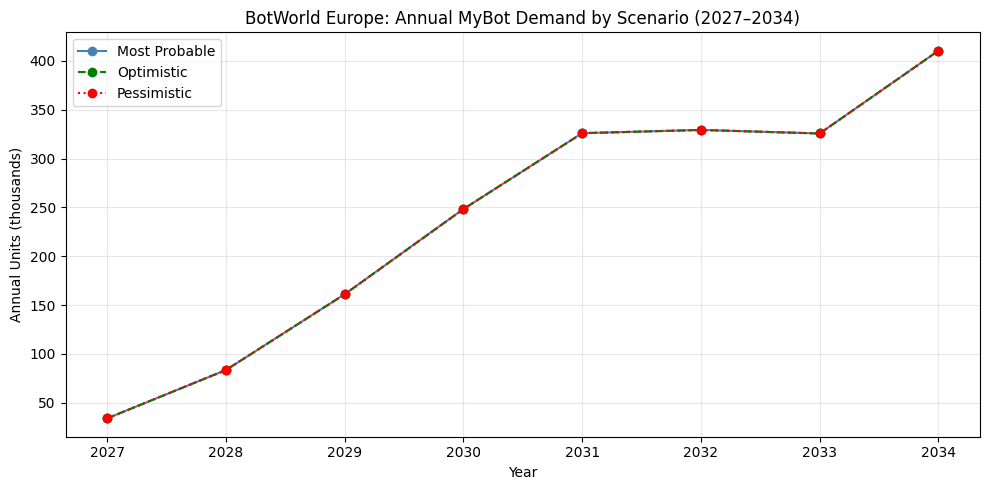

Saved: task4_annual_demand_scenarios.png


In [ ]:
# ── Plot 1: Annual demand by scenario ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
for col, color, ls in [('Most Probable','steelblue','-'),
                        ('Optimistic','green','--'),
                        ('Pessimistic','red',':')]:
    ax.plot(scen_compare['Year'], scen_compare[col]/1000,
            label=col, color=color, linestyle=ls, marker='o')
ax.set_title('BotWorld Europe: Annual MyBot Demand by Scenario (2027–2034)')
ax.set_xlabel('Year')
ax.set_ylabel('Annual Units (thousands)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

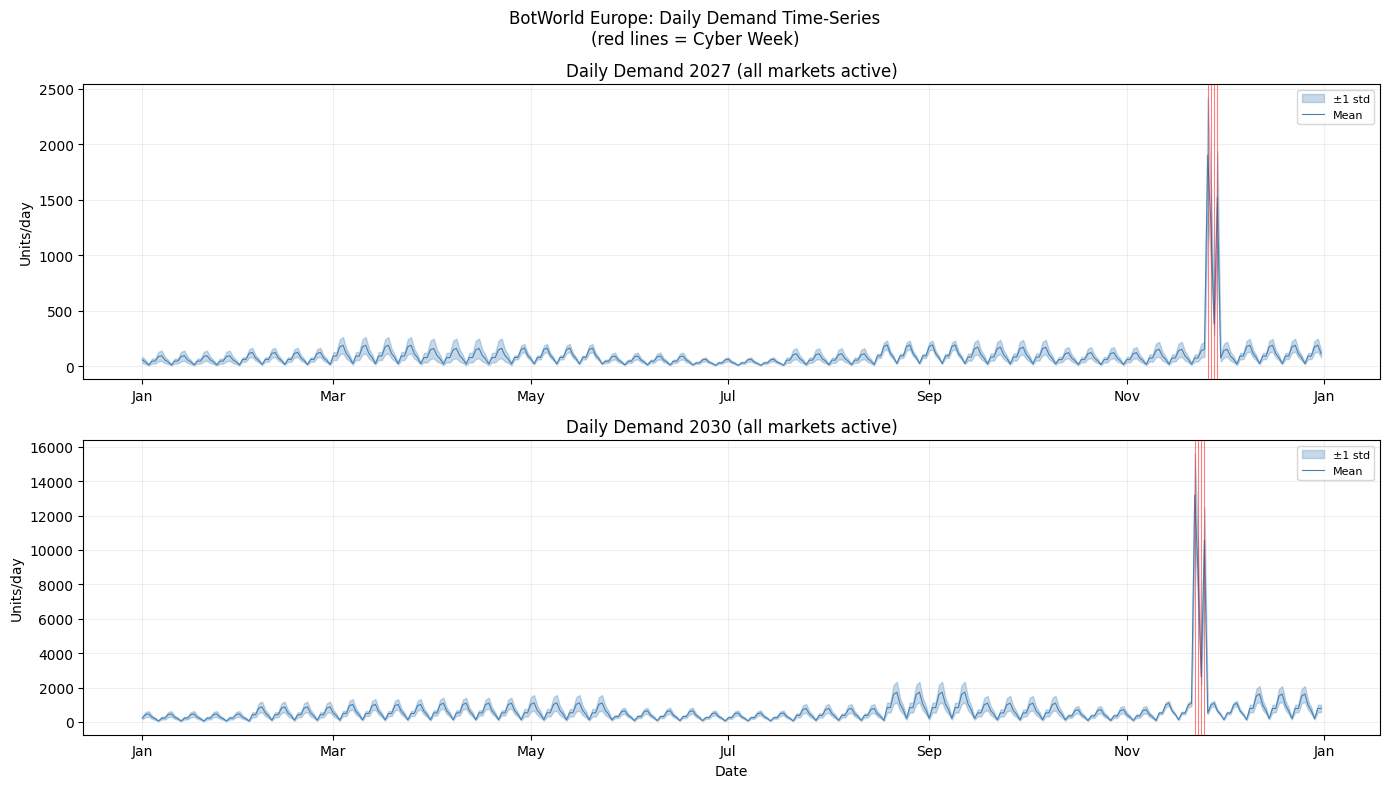

Saved: task4_daily_demand_timeseries.png


In [ ]:
# ── Plot 2: Daily demand time-series (2027 + 2030 panels) ───────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

for ax, yr in zip(axes, [2027, 2030]):
    yr_daily = daily_avg[daily_avg['date'].dt.year == yr].copy()
    ax.fill_between(yr_daily['date'],
                    yr_daily['mean_units'] - yr_daily['std_units'],
                    yr_daily['mean_units'] + yr_daily['std_units'],
                    alpha=0.3, color='steelblue', label='±1 std')
    ax.plot(yr_daily['date'], yr_daily['mean_units'],
            color='steelblue', linewidth=0.8, label='Mean')

    # Mark Cyber Week
    cw = sorted(cyber_week_dates_4(yr))
    for d in cw:
        ax.axvline(pd.Timestamp(d), color='red', alpha=0.5, linewidth=0.8)

    ax.set_title(f'Daily Demand {yr} (all markets active)')
    ax.set_ylabel('Units/day')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel('Date')
fig.suptitle('BotWorld Europe: Daily Demand Time-Series\n(red lines = Cyber Week)', fontsize=12)
plt.tight_layout()
plt.show()

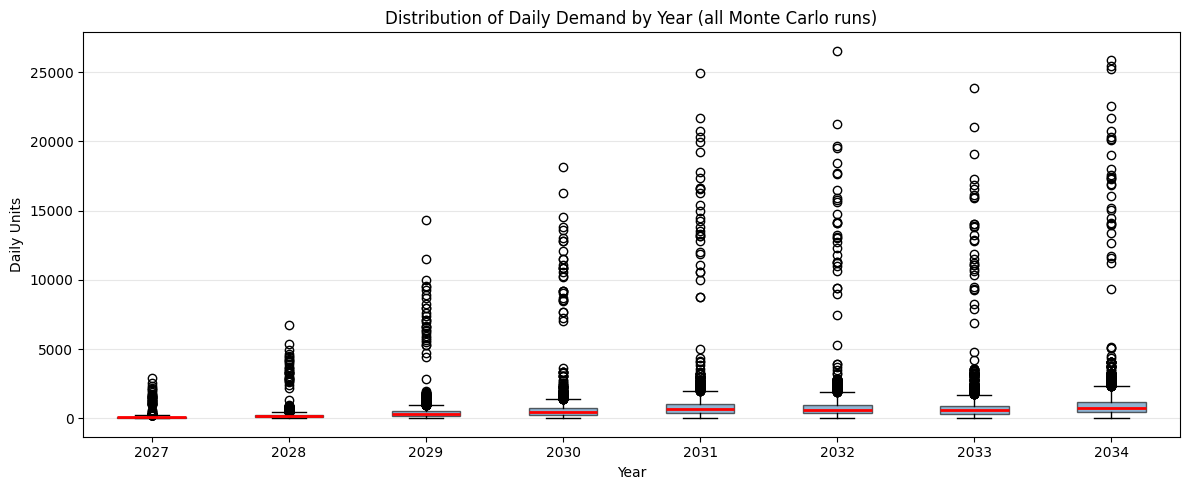

Saved: task4_daily_demand_boxplot.png


In [34]:
# ── Plot 3: Boxplot — daily demand distribution by year ──────────────────────
daily_all_sims = sim_df.groupby(['sim','date','year'])['units'].sum().reset_index()
daily_all_sims['date'] = pd.to_datetime(daily_all_sims['date'])

fig, ax = plt.subplots(figsize=(12, 5))
data_by_year = [daily_all_sims[daily_all_sims['year'] == yr]['units'].values
                for yr in YEARS]
bp = ax.boxplot(data_by_year, labels=YEARS, patch_artist=True,
                medianprops=dict(color='red', linewidth=2))
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.6)
ax.set_title('Distribution of Daily Demand by Year (all Monte Carlo runs)')
ax.set_xlabel('Year')
ax.set_ylabel('Daily Units')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('task4_daily_demand_boxplot.png', dpi=150)
plt.show()
print('Saved: task4_daily_demand_boxplot.png')

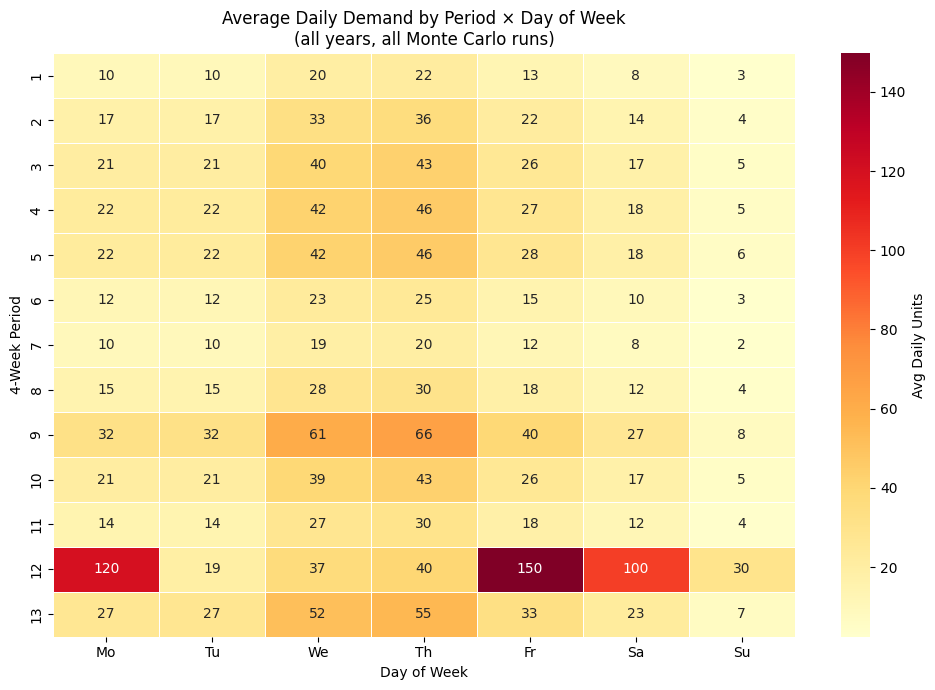

Saved: task4_heatmap_period_dow.png


In [ ]:
# ── Plot 4: Heatmap — average daily demand by period × day-of-week ───────────
sim_df_heat = sim_df.copy()
sim_df_heat['date'] = pd.to_datetime(sim_df_heat['date'])
sim_df_heat['dow'] = sim_df_heat['date'].dt.dayofweek  # 0=Mon

# Build calendar with period for each date
cal_all = pd.concat([build_year_calendar(yr) for yr in YEARS])
cal_all['date'] = pd.to_datetime(cal_all['date'])

heat_df = sim_df_heat.merge(cal_all[['date','period']], on='date', how='left')
heat_pivot = heat_df.groupby(['period','dow'])['units'].mean().unstack('dow')
heat_pivot.columns = ['Mo','Tu','We','Th','Fr','Sa','Su']

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(heat_pivot, ax=ax, cmap='YlOrRd', annot=True, fmt='.0f',
            linewidths=0.5, cbar_kws={'label': 'Avg Daily Units'})
ax.set_title('Average Daily Demand by Period × Day of Week\n(all years, all Monte Carlo runs)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('4-Week Period')
plt.tight_layout()
plt.show()


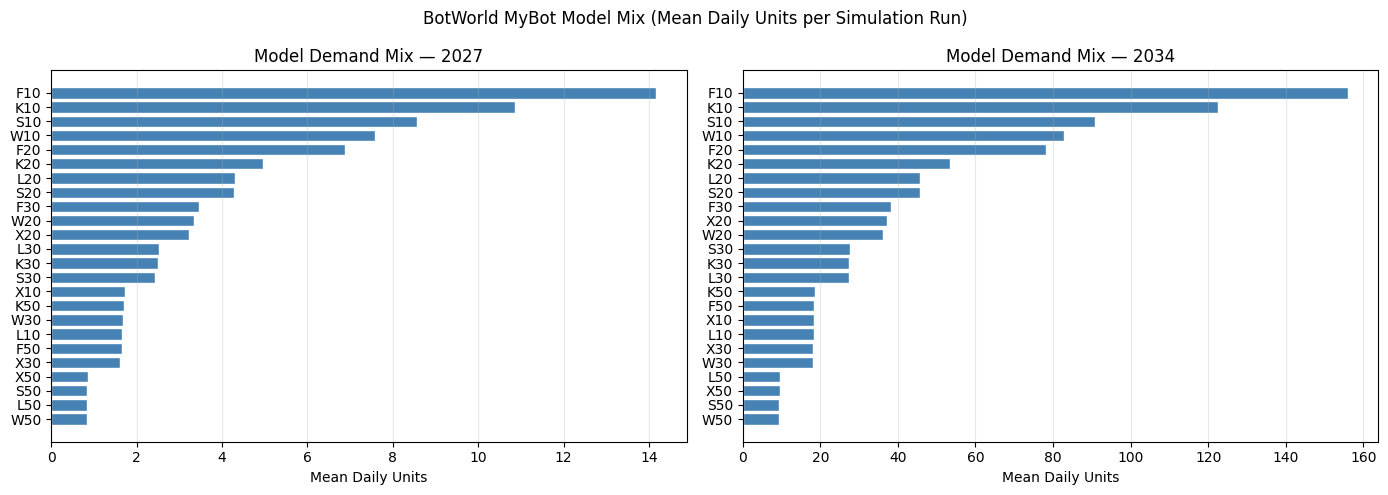

Saved: task4_model_mix.png


In [36]:
# ── Plot 5: Model mix — annual units by model (2027 vs 2034) ─────────────────
model_annual = sim_df.groupby(['year','model'])['units'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, yr in zip(axes, [2027, 2034]):
    sub = model_annual[model_annual['year'] == yr].sort_values('units', ascending=True)
    ax.barh(sub['model'], sub['units'], color='steelblue', edgecolor='white')
    ax.set_title(f'Model Demand Mix — {yr}')
    ax.set_xlabel('Mean Daily Units')
    ax.grid(True, alpha=0.3, axis='x')
plt.suptitle('BotWorld MyBot Model Mix (Mean Daily Units per Simulation Run)')
plt.tight_layout()
plt.savefig('task4_model_mix.png', dpi=150)
plt.show()
print('Saved: task4_model_mix.png')

## 11. Revenue Simulation

In [37]:
# Annual revenue by year and scenario
rev_annual = sim_df.groupby(['sim','year'])['revenue'].sum().reset_index()
rev_avg = rev_annual.groupby('year')['revenue'].agg(['mean','std']).reset_index()
rev_avg.columns = ['Year','Mean_Revenue_EUR','Std_Revenue_EUR']
rev_avg['Mean_Revenue_M'] = rev_avg['Mean_Revenue_EUR'] / 1e6
rev_avg['Std_Revenue_M']  = rev_avg['Std_Revenue_EUR'] / 1e6

print('Annual revenue (EUR millions, Most Probable, avg over sims):')
print(rev_avg[['Year','Mean_Revenue_M','Std_Revenue_M']].round(2).to_string(index=False))

Annual revenue (EUR millions, Most Probable, avg over sims):
 Year  Mean_Revenue_M  Std_Revenue_M
 2027           15.13           4.15
 2028           35.39           7.36
 2029           72.12          16.90
 2030          105.23          18.96
 2031          145.27          30.55
 2032          138.55          33.07
 2033          128.25          32.22
 2034          166.47          31.96


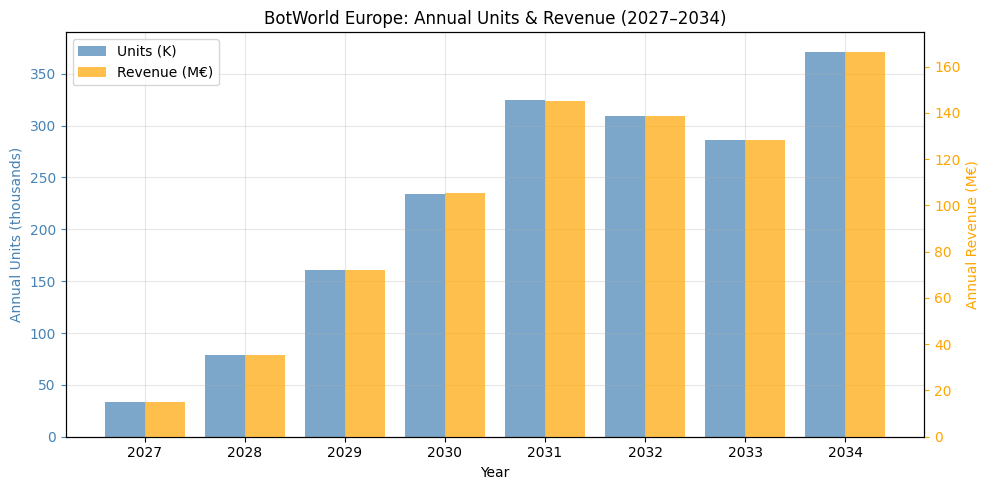

Saved: task4_annual_units_revenue.png


In [ ]:
# ── Plot 6: Revenue vs units over time ───────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.bar(sim_avg['Year'] - 0.2, sim_avg['Sim_Mean']/1000,
        width=0.4, color='steelblue', alpha=0.7, label='Units (K)')
ax2.bar(rev_avg['Year'] + 0.2, rev_avg['Mean_Revenue_M'],
        width=0.4, color='orange', alpha=0.7, label='Revenue (M€)')

ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Units (thousands)', color='steelblue')
ax2.set_ylabel('Annual Revenue (M€)', color='orange')
ax1.tick_params(axis='y', colors='steelblue')
ax2.tick_params(axis='y', colors='orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.set_title('BotWorld Europe: Annual Units & Revenue (2027–2034)')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()